# Инициализация

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, \
    Flatten, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from tensorflow import keras
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [87]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина комментария
max_comment_len = 50
#Число классов
num_classes = 6

# Загрузка тренировочных данных

In [88]:
train = pd.read_csv('toxicCommentsDataSet/toxicCommentsTrain.csv')

In [89]:
#Получение комментариев
comments = train['comment_text']

In [90]:
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Токенизация

In [91]:
tokenizer_toxic = Tokenizer(num_words=num_words)

In [92]:
#Обучение токенайзера
tokenizer_toxic.fit_on_texts(comments)

In [93]:
train_sequences = tokenizer_toxic.texts_to_sequences(comments)

In [94]:
x_train = pad_sequences(train_sequences, maxlen=max_comment_len)

# Загрузка тестовых данных

In [95]:
test_comments = pd.read_csv('toxicCommentsDataSet/toxicCommentsTest.csv')

In [96]:
test_labels = pd.read_csv('toxicCommentsDataSet/toxicCommentsTestLabels.csv')

In [97]:
test_full = pd.merge(test_comments, test_labels, on='id')

In [98]:
test = test_full[test_full['toxic'] != -1]

# Токенизация

In [99]:
test_sequences = tokenizer_toxic.texts_to_sequences(test['comment_text'])

In [100]:
y_test = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [101]:
x_test = pad_sequences(test_sequences, maxlen=max_comment_len)

# Проверка лучшей модели

In [102]:
model_toxic = Sequential()
model_toxic.add(Embedding(input_dim=num_words, output_dim=36, input_length=max_comment_len,
                          embeddings_regularizer=keras.regularizers.l2(0.0001)))
model_toxic.add(Conv1D(filters=32, kernel_size=5, activation='elu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model_toxic.add(MaxPooling1D(pool_size=2))
model_toxic.add(Flatten())
model_toxic.add(Dense(units=108, activation='elu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model_toxic.add(Dense(num_classes, activation='sigmoid'))

model_toxic.compile(optimizer='rmsprop', loss='binary_crossentropy',
                    metrics=[keras.metrics.AUC(name="auc"), "accuracy"])

model_toxic.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 36)            360000    
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 32)            5792      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 23, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 736)               0         
                                                                 
 dense_6 (Dense)             (None, 108)               79596     
                                                                 
 dense_7 (Dense)             (None, 6)                 654       
                                                      

In [103]:
history_model = model_toxic.fit(x_train,
                                y_train,
                                epochs=5,
                                batch_size=1024,
                                validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 10s 57ms/step - loss: 0.1417 - auc: 0.8931 - accuracy: 0.9612 - val_loss: 0.0898 - val_auc: 0.9599 - val_accuracy: 0.9932
Epoch 2/5
125/125 [==============================] - 7s 52ms/step - loss: 0.0819 - auc: 0.9643 - accuracy: 0.9658 - val_loss: 0.0761 - val_auc: 0.9701 - val_accuracy: 0.9467
Epoch 3/5
125/125 [==============================] - 6s 51ms/step - loss: 0.0727 - auc: 0.9699 - accuracy: 0.9579 - val_loss: 0.0708 - val_auc: 0.9693 - val_accuracy: 0.9822
Epoch 4/5
125/125 [==============================] - 6s 51ms/step - loss: 0.0690 - auc: 0.9717 - accuracy: 0.9727 - val_loss: 0.0691 - val_auc: 0.9705 - val_accuracy: 0.9822
Epoch 5/5
125/125 [==============================] - 6s 51ms/step - loss: 0.0667 - auc: 0.9728 - accuracy: 0.9847 - val_loss: 0.0694 - val_auc: 0.9671 - val_accuracy: 0.9941


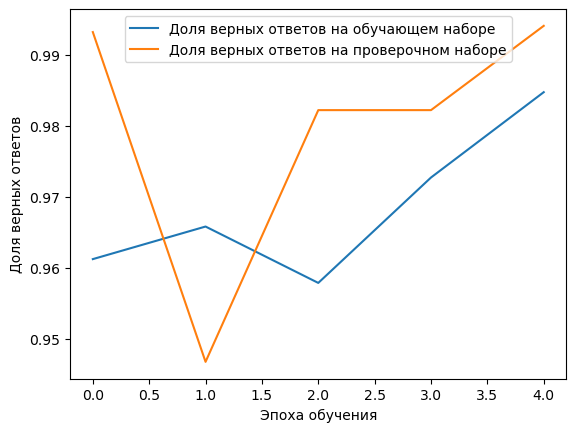

In [104]:
plt.plot(history_model.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_model.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [105]:
model_toxic.evaluate(x_test, y_test)
len(x_test)

2000/2000 [==============================] - 7s 4ms/step - loss: 0.0833 - auc: 0.9634 - accuracy: 0.9975


63978

In [106]:
comment = "COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK"

In [107]:
sequence_toxic = tokenizer_toxic.texts_to_sequences([comment])

In [108]:
data_toxic = pad_sequences(sequence_toxic, maxlen=max_comment_len)

In [109]:
model_toxic.predict(data_toxic)

1/1 [==============================] - 0s 184ms/step


array([[0.897078  , 0.03030412, 0.4762518 , 0.01069032, 0.38770282,
        0.03977123]], dtype=float32)

# Сохранение модели токсичности

In [110]:
model_toxic.save('model_toxic.h5')
#loaded_model_toxic = tf.keras.models.load_model('model_toxic')
#tf.saved_model.save(loaded_model_toxic, 'model_toxic_saved_model')

# ОБУЧЕНИЕ ЭКШЕНАМ

In [111]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина экшена
max_action_len = 50
#Число классов
num_classes = 15

# Загрузка тренировочных данных

In [112]:
train = pd.read_csv('actionsNPCDataSet/trainActions.csv', header=None,
                    names=['class', 'text'])

In [113]:
#Получение экшенов
actions = train['text']

In [114]:
y_train = utils.to_categorical(train['class'] - 1, num_classes)

# Токенизация

In [115]:
tokenizer_action = Tokenizer(num_words=num_words)

In [116]:
#Обучение токенайзера
tokenizer_action.fit_on_texts(actions)

In [117]:
train_sequences = tokenizer_action.texts_to_sequences(actions)

In [118]:
x_train = pad_sequences(train_sequences, maxlen=max_action_len)

# Загрузка тестовых данных

In [119]:
test = pd.read_csv('actionsNPCDataSet/actionsTest.csv', header=None,
                           names=['class', 'text'])

In [120]:
#Получение экшенов
test_actions = test['text']

In [121]:
y_test = utils.to_categorical(test['class'] - 1, num_classes)

# Токенизация

In [122]:
test_sequences = tokenizer_action.texts_to_sequences(test_actions)

In [123]:
x_test = pad_sequences(test_sequences, maxlen=max_action_len)

# Модель

In [124]:
model_action = Sequential()
model_action.add(Embedding(input_dim=num_words, output_dim=116, input_length=max_action_len,
                           embeddings_regularizer=keras.regularizers.l2(0.0001)))
model_action.add(
    Conv1D(filters=172, kernel_size=3, activation='selu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model_action.add(MaxPooling1D(pool_size=2))
model_action.add(Flatten())
model_action.add(Dense(units=140, activation='selu', kernel_regularizer=keras.regularizers.l2(0.001)))
model_action.add(Dense(num_classes, activation='softmax'))

model_action.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_action.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 116)           1160000   
                                                                 
 conv1d_4 (Conv1D)           (None, 48, 172)           60028     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 24, 172)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 4128)              0         
                                                                 
 dense_8 (Dense)             (None, 140)               578060    
                                                                 
 dense_9 (Dense)             (None, 15)                2115      
                                                      

In [125]:
history_model = model_action.fit(x_train,
                                 y_train,
                                 epochs=5,
                                 batch_size=128,
                                 validation_split=0.2)

Epoch 1/5
45/45 [==============================] - 5s 72ms/step - loss: 2.0251 - accuracy: 0.5488 - val_loss: 0.9240 - val_accuracy: 0.8278
Epoch 2/5
45/45 [==============================] - 3s 68ms/step - loss: 0.4832 - accuracy: 0.9551 - val_loss: 0.3913 - val_accuracy: 0.9433
Epoch 3/5
45/45 [==============================] - 3s 65ms/step - loss: 0.2146 - accuracy: 0.9917 - val_loss: 0.2460 - val_accuracy: 0.9653
Epoch 4/5
45/45 [==============================] - 3s 65ms/step - loss: 0.1318 - accuracy: 0.9972 - val_loss: 0.1821 - val_accuracy: 0.9738
Epoch 5/5
45/45 [==============================] - 3s 67ms/step - loss: 0.0944 - accuracy: 0.9986 - val_loss: 0.1583 - val_accuracy: 0.9773


In [126]:
model_action.evaluate(x_test, y_test)

44/44 [==============================] - 0s 8ms/step - loss: 0.1442 - accuracy: 0.9843


[0.14417694509029388, 0.9842857122421265]

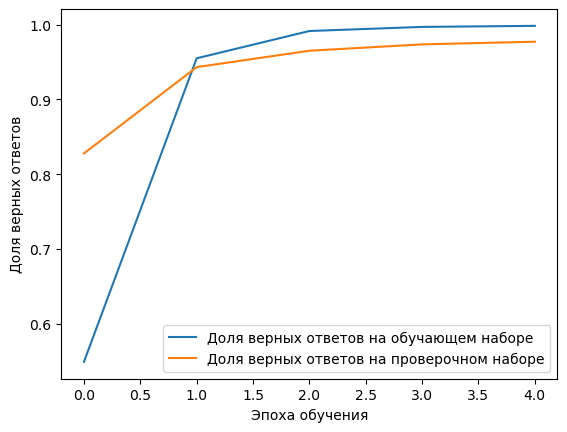

In [127]:
plt.plot(history_model.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_model.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [128]:
model_action.evaluate(x_test, y_test)

44/44 [==============================] - 1s 15ms/step - loss: 0.1442 - accuracy: 0.9843


[0.14417694509029388, 0.9842857122421265]

In [129]:
# Сохранение модели классификации экшенов

In [130]:
model_action.save('model_action.h5')
#loaded_model_action = tf.keras.models.load_model('model_action')
#tf.saved_model.save(loaded_model_action, 'model_action_saved_model')

# ПЕРЕДАЧА ТЕКСТА

In [140]:
classes_toxic = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
classes_action = ['Tell about you', 'Tell about world', 'Remind task', 'Give advice on battle tactics',
                  'Give advice on possible completion of the task', 'Train sword', 'Train axe', 'Train mace',
                  'Train fist fight', 'Heal player', 'Close combat', 'Ranged combat', 'Make an exchange of resources',
                  'Crack the lock', 'Explore the territory']

In [166]:
comment = "I'm dying. Quickly do something stupid NPC"

# Обработка текста на токсичность

In [167]:
sequence_toxic = tokenizer_toxic.texts_to_sequences([comment])

In [168]:
data_toxic = pad_sequences(sequence_toxic, maxlen=max_comment_len)

# Получение результата

In [169]:
predictions_toxic = np.where(model_toxic.predict(data_toxic)[0] > 0.5)[0]

1/1 [==============================] - 0s 320ms/step


# Обработка текста на действие

In [170]:
sequence_action = tokenizer_action.texts_to_sequences([comment])

In [171]:
data_action = pad_sequences(sequence_action, maxlen=max_action_len)

# Получение результата

In [172]:
prediction_action = np.argmax(model_action.predict(data_action))

1/1 [==============================] - 0s 100ms/step


In [173]:
print('Text:', comment)
for prediction_toxic in predictions_toxic:
    print('Toxic:', classes_toxic[prediction_toxic])
print('Action:', classes_action[prediction_action])

Text: I'm dying. Quickly do something stupid NPC
Toxic: toxic
Action: Heal player
